Course: INF552

Name: Jiashi Chen

USC ID: 4684194123

# Part 1: Implementation

## K-means algorithm

In [1]:
import numpy as np
import pandas as pd
import random
import itertools
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

### Obtain data

In [2]:
data = pd.read_csv("clusters.txt", names=["x1", "x2"])
data.head()

,x1,x2
0,-1.861331,-2.991683
1,-2.170092,-3.292318
2,-1.014081,0.385795
3,-2.912943,-2.579539
4,0.035721,-0.799698


### Pick k random centroids

In [3]:
def pick_random_centroids(k):
    x1 = data.iloc[:,0]
    x2 = data.iloc[:,1]
    random_n_list = list(itertools.product(range(int(x1.min()), int(x1.max())), range(int(x2.min()), int(x2.max()))))
    return random.sample(random_n_list, k)

### L2-norm

In [4]:
def calculte_distance(point1, point2):
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i])**2
    return np.sqrt(distance)

### Assign data to closet centroids

In [5]:
def assign_data(data, centroids):
    assign_result_list = []
    for index, row in data.iterrows():
        closet_centroid = -1
        closet_distance = -1
        for i in range(len(centroids)):
            if closet_centroid == -1 or closet_distance > calculte_distance(row, centroids[i]):
                closet_centroid = i
                closet_distance = calculte_distance(row, centroids[i])
        assign_result_list.append(closet_centroid)
    return assign_result_list

### Recompute the centroid for each cluster

In [6]:
def regain_centroids(data, label, k):
    centroids = []
    for i in range(k):
        data_same_centroid = []
        for j in range(len(label)):
            if label[j] == i:
                data_same_centroid.append(list(data.iloc[j,]))
        centroids.append(np.mean(data_same_centroid, axis = 0).tolist())
    return centroids

### Obtain the final centroids

In [7]:
def K_means(data, k):
    random_centroids = pick_random_centroids(k)
    label = assign_data(data, random_centroids)
    new_centroids = regain_centroids(data, label, k)
    while True:
        old_centroids = new_centroids
        label = assign_data(data, old_centroids)
        new_centroids = regain_centroids(data, label, k)
        if old_centroids == new_centroids:
            break
    return new_centroids

In [8]:
centroids = K_means(data, 3)
centroids

[[-0.974765718082353, -0.6841930411764707],
 [5.620165734970588, 5.026226344176472],
 [3.083182557032258, 1.7762137380322585]]

### Predict the label of each point

In [9]:
labels = assign_data(data, centroids)

### Plot the clustering result

In [10]:
def plotAssign(data, labels):
    for i in range(1,len(labels)):
        if labels[i] == 0:
            plt.scatter(data.iloc[i, 0], data.iloc[i, 1], s=15, c='red')
        elif labels[i] == 1:
            plt.scatter(data.iloc[i, 0], data.iloc[i, 1], s=15, c='blue')
        elif labels[i] == 2:
            plt.scatter(data.iloc[i, 0], data.iloc[i, 1], s=15, c='green')

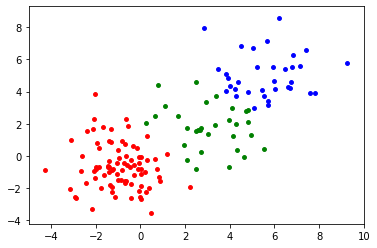

In [11]:
plotAssign(data, labels)

## Expectation Maximization algorithm

### Obtain data

In [12]:
data = pd.read_csv("clusters.txt", names=["x1", "x2"])
data.head()

,x1,x2
0,-1.861331,-2.991683
1,-2.170092,-3.292318
2,-1.014081,0.385795
3,-2.912943,-2.579539
4,0.035721,-0.799698


### Assign $r_{ic}$ randomly

In [13]:
def obtain_random_r(data, k):
    r_list = []
    for i in range(data.shape[0]):
        r = np.array([random.random(), random.random(), random.random()])
        r = r/sum(r)
        r_list.append(r.tolist())
    return r_list

### Figure out $\Pi_c$, $\mu_c$, $\Sigma_c$

In [14]:
def calculte_mu(data, r, k):
    mu_list = []
    summation = 0
    for i in range(k):
        for index, row in data.iterrows():
            summation += row * r[index][i]
        summation = summation / np.sum(r, axis = 0)[i]
        mu_list.append(summation.tolist())
    
    return mu_list        

In [15]:
def calculte_Sigma(data, r, k, mu):
    Sigma_list = []
    
    for i in range(k):
        summation = 0
        for index, row in data.iterrows():
            deviation = row - mu[i]
            deviation = np.array([deviation])
            summation += deviation.T.dot(deviation)*r[index][i]
        summation = summation / np.sum(r, axis = 0)[i]
        Sigma_list.append(np.asmatrix(summation))
    
    return Sigma_list

In [16]:
def calculte_Pi(data, r):
    amount_data = data.shape[0]
    return np.sum(r, axis = 0)/amount_data

### Multivariable Gaussians

In [17]:
def multi_gaussians(x, Pi, mu, Sigma):
    size = len(x)
    
    #print(np.linalg.det(Sigma))
    part1 = 1/ (np.power((2*np.pi), size/2) * np.power(np.linalg.det(Sigma), 1/2))
    
    deviation = np.asmatrix(x - mu)
    
    part2 = np.power(math.e, -1/2 * (deviation * Sigma.I * deviation.T))
    return (Pi * part1 * part2).tolist()[0][0]

### Recomputer $r_{ic}$

In [18]:
def calculate_r(data, Pi, mu, Sigma, k):
    
    gaussians_data = []
    
    for index, row in data.iterrows():
        gaussians_Xi = []
        for i in range(k):
            gaussians_Xi.append(multi_gaussians(row, Pi[i], mu[i], Sigma[i]))
        gaussians_data.append(gaussians_Xi)
    
    r_list = []
    
    for Xi in gaussians_data:
        summation = sum(Xi)
        Xi = np.array(Xi)
        r_list.append((Xi/summation).tolist())
    
    return r_list    

### Obtain final arguments

In [19]:
def GMM(data, k):
    new_r = obtain_random_r(data, k)
    count = 0
    
    while True:
        count += 1
        old_r = new_r
        mu = calculte_mu(data, old_r, k)
        Sigma = calculte_Sigma(data, old_r, k, mu)
        Pi = calculte_Pi(data, old_r)
        new_r = calculate_r(data, Pi, mu, Sigma, k)
        if (np.abs(np.array(new_r) - np.array(old_r)) < 0.005).all():
            break
        if count > 500:
            break;
    
    return mu, Sigma, Pi

In [66]:
Mu, Sigma, Pi = GMM(data, 3)
print("The list of mean: ")
print(Mu)
print("---------")
print("The list of covariance matrix: ")
print(Sigma)
print("--------")
print("The list of amplitude: ")
print(Pi)

The list of mean: 
[[3.73099187120709, 2.9855455782775535], [-0.9363099371558942, -0.5785580959583669], [6.155129816334989, 4.384107437555044]]
---------
The list of covariance matrix: 
[matrix([[2.52092325, 1.69173506],
        [1.69173506, 5.88450297]]), matrix([[ 1.20167293, -0.05148645],
        [-0.05148645,  2.06069071]]), matrix([[1.83092718, 0.92832769],
        [0.92832769, 1.29369472]])]
--------
The list of amplitude: 
[0.31599382 0.5657184  0.11828778]


### Predict the label of each point

In [21]:
def predict_point(data, Mu, Sigma, Pi):
    labels = []
    k = len(Mu)
    for index, row in data.iterrows():
        Gaussian_each = []
        for i in range(k):
            Gaussian_each.append(multi_gaussians(row, Pi[i], Mu[i], Sigma[i]))
        labels.append(np.argmax(Gaussian_each))
    return labels

### Plot the clustering result

In [67]:
labels = predict_point(data, Mu, Sigma, Pi)

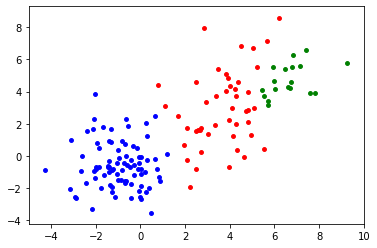

In [68]:
plotAssign(data, labels)

# Part 2: Software Familiarization 

## Import necessary packages and obtain data

In [69]:
from sklearn.cluster import KMeans
from sklearn import mixture

In [70]:
data = pd.read_csv("clusters.txt", names=["x1", "x2"])
data.head()

,x1,x2
0,-1.861331,-2.991683
1,-2.170092,-3.292318
2,-1.014081,0.385795
3,-2.912943,-2.579539
4,0.035721,-0.799698


## K-means algorithm

In [71]:
estimator = KMeans(n_clusters=3)
estimator.fit(data)
centroids = estimator.cluster_centers_
centroids

array([[-0.97476572, -0.68419304],
       [ 5.62016573,  5.02622634],
       [ 3.08318256,  1.77621374]])

In [72]:
labels = estimator.predict(data)

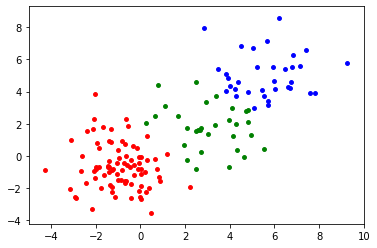

In [73]:
plotAssign(data, labels)

## Expectation Maximization algorithm

In [74]:
modele = mixture.GaussianMixture(n_components=3, covariance_type='full')
modele.fit(data)
print(modele.means_)

[[ 3.13133022  1.71921331]
 [-0.96251642 -0.64669019]
 [ 5.47804494  4.85130933]]


In [75]:
labels = modele.predict(data)

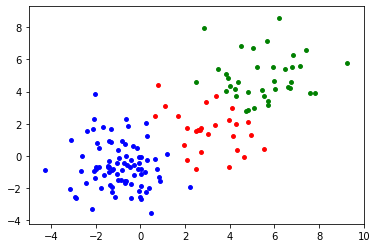

In [76]:
plotAssign(data, labels)